In [3]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import Lattice2D, compass_to_surface
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import pymatching

%load_ext autoreload
%autoreload 2

In [68]:
"""pick the compass code"""
dim = 3
lat = Lattice2D(dim, dim)

coloring = np.random.randint(-1, 2, size=(dim-1)**2)
lat.color_lattice(coloring)
print(lat)

000---001---002
 |  ░  |  ░  |
003---004---005
 |  ░  |  ░  |
006---007---008



### Scheme for Decoder Graph (Code Capacity Model)
* Given a surface density code (a type of CSS code), we can construct decoder graphs for both $X$ and $Z$-type stabilizers
* Each vertex of the graph corresponds to a stabilizer and each edge corresponds to a qubit
    * In this scheme, if a qubit is involved in more than 2 stabilizer checks, then we can have a hyper-edge.

In [69]:
def get_parity_check_mat(stabs: List, stab_type: str):
    """
    Define parity check matrix for 'stabs' of 'stab_type' 

    Params:
    * stabs - List of stabilizers in string form where 'X' denotes X, 'Z' denotes Z and '_' denotes I
    * stab_type - Either 'X' or 'Z' as these are CSS codes
    """
    pc_mat = np.zeros((len(stabs), len(stabs[0])), dtype=int)
    for i, stab in enumerate(stabs):
        pc_mat[i] = np.array([1 * (lambda x : x == stab_type)(x) for x in stab])

    return pc_mat


In [70]:
pc_mat_X = get_parity_check_mat(lat.getSx(), stab_type='X')
pc_mat_Z = get_parity_check_mat(lat.getSz(), stab_type='Z')

In [71]:
def construct_decoder_graph(pc_mat : np.array, num_rounds: int = 1):
    decode_graph = nx.MultiGraph()
    color_map = []

    for k in range(num_rounds):
        curr_decode_graph = nx.MultiGraph()
        for i, stab in enumerate(pc_mat):
            curr_decode_graph.add_node(str(i) + "," + str(k))

        for j, qubit in enumerate(pc_mat.T):
            stabs = [str(i) + "," + str(k) for i in range(len(qubit)) if qubit[i] == 1]
            if (len(stabs) == 1):
                stabs = tuple(stabs + ['B' + "," + str(k)])
                curr_decode_graph.add_edge(*stabs)
            else:
                curr_decode_graph.add_edge(*tuple(stabs))

        for node in curr_decode_graph:
            if(str(node) == 'B' + "," + str(k)):
                color_map.append('tab:red')
            else:
                color_map.append('tab:blue')

        if (k > 0):
            for node in curr_decode_graph:
                decode_graph.add_edge(node[0] + "," + str(k), 
                                           node[0] + ',' + str(k - 1))
        decode_graph = nx.compose(decode_graph, curr_decode_graph)

    return decode_graph, color_map

In [72]:
decode_graph_X, color_map_X = construct_decoder_graph(pc_mat_X, num_rounds=3)
decode_graph_Z, color_map_Z = construct_decoder_graph(pc_mat_Z, num_rounds = 3)

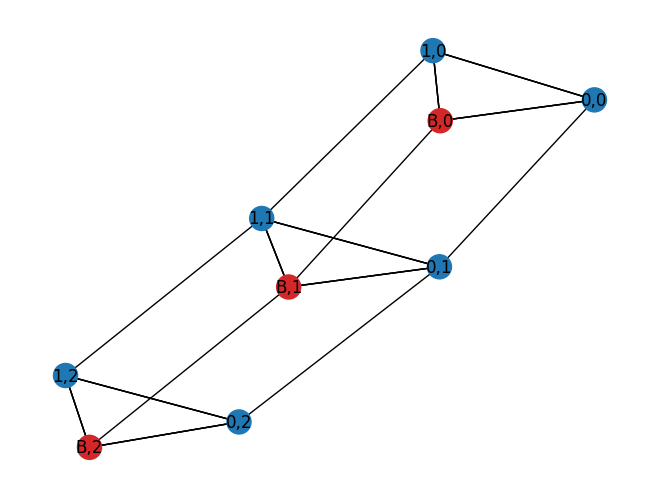

In [73]:
nx.draw(decode_graph_X, node_color = color_map_X, with_labels=True)

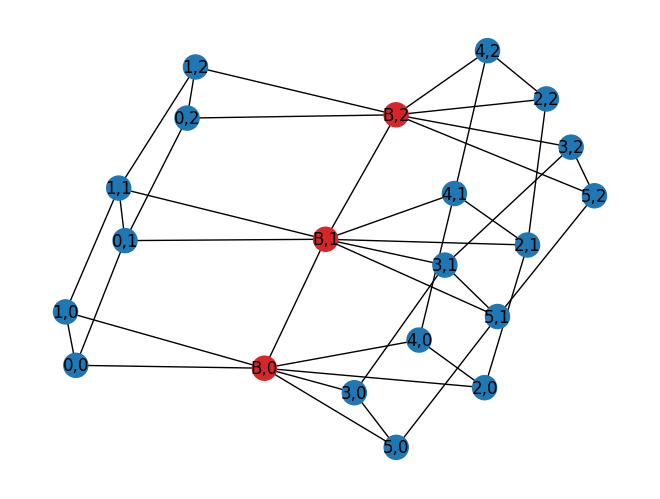

In [74]:
nx.draw(decode_graph_Z, node_color = color_map_Z, with_labels=True)

In [21]:
print("X PARITY CHECKk")
print(pc_mat_X)
print('\n')
print("Z PARITY CHECK")
print(pc_mat_Z)

X PARITY CHECKk
[[1 0 0 1 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0]
 [0 0 1 0 0 1 0 0 0]
 [0 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 1 0 0 1]]


Z PARITY CHECK
[[1 1 0 1 1 0 1 1 0]
 [0 1 1 0 1 1 0 1 1]]


In [16]:
nx.nx_agraph.write_dot(decode_graph_X, "decoder_graph_files/decode_graph_X.dot")
!neato -T png "decoder_graph_files/decode_graph_X.dot" > "decoder_graph_files/decode_graph_X.png"

nx.nx_agraph.write_dot(decode_graph_Z, "decoder_graph_files/decode_graph_Z.dot")
!neato -T png "decoder_graph_files/decode_graph_Z.dot" > "decoder_graph_files/decode_graph_Z.png"